How many entries were made per day?

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
"""
Make a dataframe showing only whether meals were successfully recorded, and remove nearby ones

"""
import pandas as pd

from ema import clean

# Read data in
meal_df = clean.cleaned_smartwatch(keep_catchups=False)

# Collapse meal type to positive/negative response
assert set(meal_df["meal_type"].unique()) == {
    "Meal",
    "Drink",
    "Snack",
    "No food/drink",
    "No response",
}, set(meal_df["meal_type"].unique())
meal_df["pos_entry"] = meal_df["meal_type"].isin({"Meal", "Drink", "Snack", "No Food"})

# Column for day of the study
meal_df["day"] = meal_df["delta"].dt.days

# Sort by time
meal_df.reset_index(inplace=True)
meal_df.sort_values(by="Datetime", inplace=True)

meal_df["keep"] = True
for (p_id, time), group in meal_df.groupby(
    ["p_id", pd.Grouper(key="Datetime", freq="10min")]
):
    # If there are multiple close together entries
    if len(group) > 1:
        # Keep only first one if theyre all positive
        if group["pos_entry"].all():
            meal_df.loc[group.index[1:], "keep"] = False

        # Keep the first positive one if there is a mix
        elif group["pos_entry"].any():
            first_positive_index = group[group["pos_entry"]].index[0]
            other_indices = group.index[group.index != first_positive_index]
            meal_df.loc[other_indices, "keep"] = False

        # Keep only the first one if theyre all negative
        else:
            meal_df.loc[group.index[1:], "keep"] = False

meal_df.set_index("Datetime", inplace=True)

# Remove also No responses at 8am since these are probably missed catchups
meal_df.loc[
    ((meal_df["pos_entry"] == False) & (meal_df.index.hour == 8)), "keep"
] = False

meal_df = meal_df[meal_df["keep"]]
meal_df.drop(columns=["keep"], inplace=True)

In [11]:
"""
Find how many entries were made per day

"""
import numpy as np

pos_entries_per_day = []
neg_entries_per_day = []
total_entries_per_day = []
pos_days = []
neg_days = []
total_days = []
for (_, day), group in meal_df.groupby(["p_id", "day"]):
    value_counts = group["pos_entry"].value_counts()
    if len(group) > 20:
        print(group[["p_id", "meal_type"]])
    try:
        pos_entries_per_day.append(value_counts[True])
        pos_days.append(day)
    except KeyError:
        ...

    try:
        neg_entries_per_day.append(value_counts[False])
        neg_days.append(day)
    except KeyError:
        ...

    total_entries_per_day.append(len(group))
    total_days.append(day)


pos_entries_per_day = np.array(pos_entries_per_day)
neg_entries_per_day = np.array(neg_entries_per_day)
pos_days = np.array(pos_days)
neg_days = np.array(neg_days)
total_entries_per_day = np.array(total_entries_per_day)
total_days = np.array(total_days)

                     p_id      meal_type
Datetime                                
2022-02-16 09:02:47  1195  No food/drink
2022-02-16 10:03:07  1195           Meal
2022-02-16 11:03:18  1195  No food/drink
2022-02-16 12:03:22  1195  No food/drink
2022-02-16 12:37:52  1195          Drink
2022-02-16 12:41:49  1195          Drink
2022-02-16 12:55:37  1195          Snack
2022-02-16 13:03:55  1195           Meal
2022-02-16 13:37:45  1195           Meal
2022-02-16 13:54:42  1195           Meal
2022-02-16 14:04:54  1195           Meal
2022-02-16 14:38:52  1195           Meal
2022-02-16 14:48:10  1195           Meal
2022-02-16 14:56:33  1195           Meal
2022-02-16 15:09:28  1195           Meal
2022-02-16 15:44:24  1195           Meal
2022-02-16 15:50:32  1195           Meal
2022-02-16 16:12:52  1195           Meal
2022-02-16 17:14:52  1195    No response
2022-02-16 18:14:59  1195          Drink
2022-02-16 19:15:02  1195  No food/drink
2022-02-16 20:17:02  1195    No response
                

In [9]:
"""
Find the mean compliance rate

"""
n_participants = len(meal_df["p_id"].unique())
n_days = len(meal_df["day"].unique())

expected_per_day = 12
expected = expected_per_day * n_days * n_participants
actual = total_entries_per_day.sum()

fraction = actual / expected

print(np.unique(total_entries_per_day, return_counts=True))


(array([ 1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 22, 25, 28]), array([  2,   5,   3,   6,   3,   2,   1,   1,   3,   2, 437,  14,   9,
         1,   3,   1,   1,   1,   1,   1,   1]))


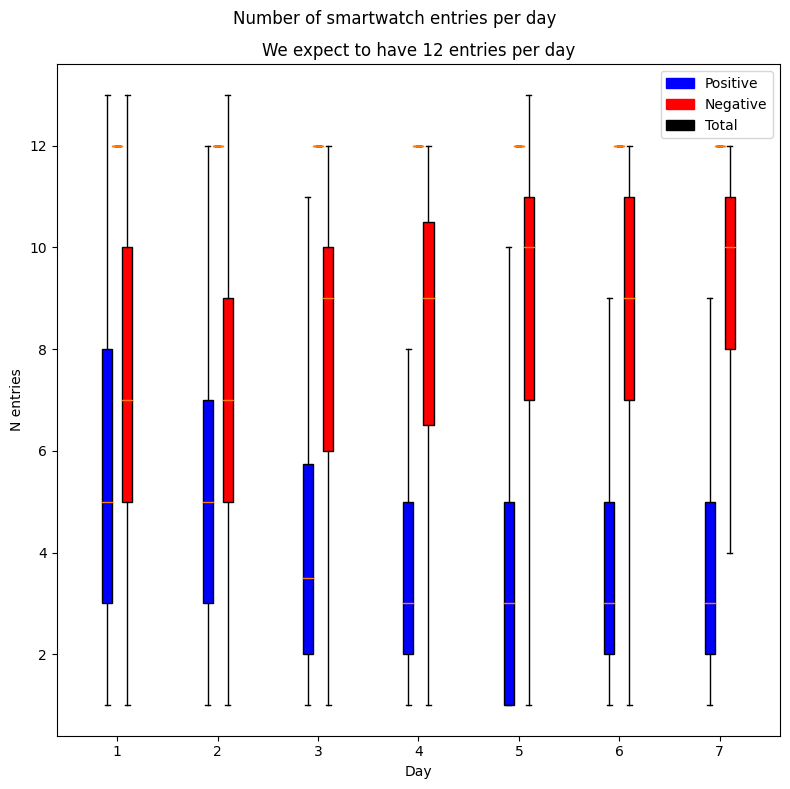

In [10]:
"""
Boxplot of how many positive/negative/total entries were made per day

"""

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

fig, axis = plt.subplots(figsize=(8, 8))

box_kw = {"widths": 0.1, "showfliers": False, "patch_artist": True}
days = np.arange(1, 8)

for day in days:
    pos_box = axis.boxplot(
        pos_entries_per_day[pos_days == day],
        positions=[day - box_kw["widths"]],
        **box_kw,
    )
    for box in pos_box["boxes"]:
        box.set_facecolor("b")

    neg_box = axis.boxplot(
        neg_entries_per_day[neg_days == day],
        positions=[day + box_kw["widths"]],
        **box_kw,
    )
    for box in neg_box["boxes"]:
        box.set_facecolor("r")

    total_box = axis.boxplot(
        total_entries_per_day[total_days == day], positions=[day], **box_kw
    )
    for box in total_box["boxes"]:
        box.set_facecolor("k")

axis.set_xticks(days, days)

axis.set_xlabel("Day")
axis.set_ylabel("N entries")

axis.legend(
    [Patch(color="b"), Patch(color="r"), Patch(color="k")],
    ["Positive", "Negative", "Total"],
    loc="upper right",
)

fig.suptitle("Number of smartwatch entries per day")
axis.set_title("We expect to have 12 entries per day")

fig.tight_layout()

fig.savefig("img/entries_per_day_boxplot.png")

In [ ]:
"""
Run a multi level model on whether the number of entries per day is predicted by the day of the study

"""
# Build a dataframe containing the right data
# Needs a column for the day of the study
# Needs a column for the number of entries on this day
# Needs a column for p_id
# Build model - random effect for p_id, fixed effect for day
# Run model